# 导入相关库

In [42]:
import pandas as pd
import numpy as np
import os
import time
import cv2
from PIL import Image
from PIL import ImageEnhance
import itertools
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = 'SimHei'
plt.rcParams['axes.unicode_minus'] = False

from sklearn.ensemble import RandomForestClassifier#决策树
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier #神经网络
from sklearn.svm import SVC#支持向量机
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score, confusion_matrix
from sklearn.metrics import roc_curve, auc,recall_score  #
from sklearn.preprocessing import StandardScaler
# 绘制混淆矩阵函数
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
#忽略警告
import warnings
warnings.filterwarnings('ignore')

# 数据探索

* 读取图片数据

In [5]:
#读取图片
nofog_path="fogs/0/"
fog_path="fogs/1/"
fog=os.listdir(fog_path)
nofog=os.listdir(nofog_path)

---
* 查看烟火图片

有明显烟/火出现的图片：


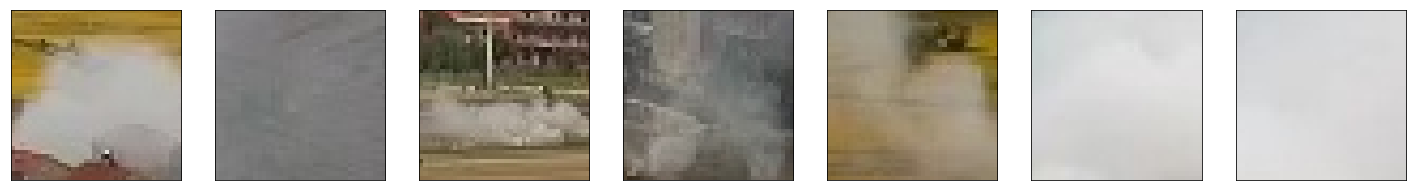

In [29]:
plt.figure(figsize=(25,25))
print("有明显烟/火出现的图片：")
for i in range(1,8):
    ax=plt.subplot(1,7,i)
    path=fog_path+fog[i]
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(Image.open(path))

---
* 查看无烟火图片

无明显烟/火出现的图片：


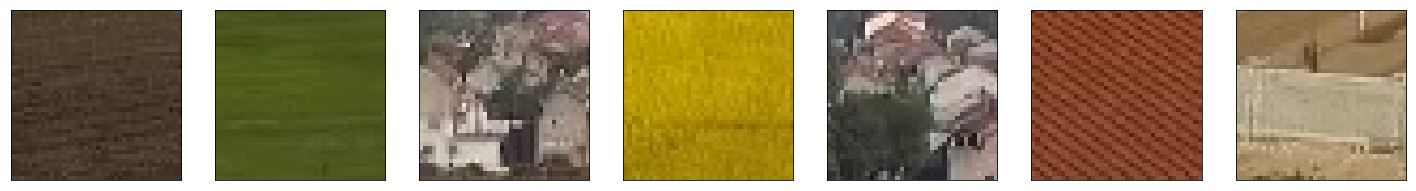

In [25]:
plt.figure(figsize=(25,25))
print("无明显烟/火出现的图片：")
for i in range(1,8):
    ax=plt.subplot(1,7,i)
    path=nofog_path+nofog[i]
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(Image.open(path))
    #暗通道去雾

<BarContainer object of 2 artists>

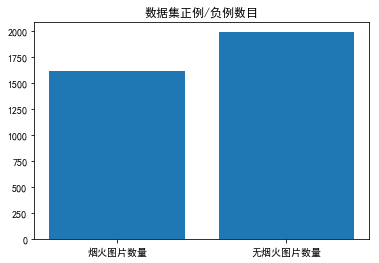

In [8]:
plt.title("数据集正例/负例数目")
plt.bar(["烟火图片数量","无烟火图片数量"],[len(fog),len(nofog)])

---
# 数据预处理
## 暗通道去雾算法
   * 这个去雾算法只针对彩色图像，而且对于低对比度的天空或者水面背景的去雾效果会产生块效应，去雾效果不好。   
      ** 因此在调用去雾算法前，先提高了图片的对比度 **
   * 再通过计算图片数据的像素均值作为特征进行训练

---
* 暗通道去雾算法实现

In [9]:
   
def zmMinFilterGray(src, r=7):  
    '''''最小值滤波，r是滤波器半径'''  
    return cv2.erode(src,np.ones((2*r-1,2*r-1)))
# =============================================================================
#     if r <= 0:  
#         return src  
#     h, w = src.shape[:2]  
#     I = src  
#     res = np.minimum(I  , I[[0]+range(h-1)  , :])  
#     res = np.minimum(res, I[range(1,h)+[h-1], :])  
#     I = res  
#     res = np.minimum(I  , I[:, [0]+range(w-1)])  
#     res = np.minimum(res, I[:, range(1,w)+[w-1]])  
# =============================================================================
 #   return zmMinFilterGray(res, r-1)  
def guidedfilter(I, p, r, eps):  
    '''''引导滤波，直接参考网上的matlab代码'''  
    height, width = I.shape  
    m_I = cv2.boxFilter(I, -1, (r,r))  
    m_p = cv2.boxFilter(p, -1, (r,r))  
    m_Ip = cv2.boxFilter(I*p, -1, (r,r))  
    cov_Ip = m_Ip-m_I*m_p  
   
    m_II = cv2.boxFilter(I*I, -1, (r,r))  
    var_I = m_II-m_I*m_I  
   
    a = cov_Ip/(var_I+eps)  
    b = m_p-a*m_I  
   
    m_a = cv2.boxFilter(a, -1, (r,r))  
    m_b = cv2.boxFilter(b, -1, (r,r))  
    return m_a*I+m_b  
   
def getV1(m, r, eps, w, maxV1):  #输入rgb图像，值范围[0,1]  
    '''''计算大气遮罩图像V1和光照值A, V1 = 1-t/A'''  
    V1 = np.min(m,2)                                         #得到暗通道图像  
    V1 = guidedfilter(V1, zmMinFilterGray(V1,7), r, eps)     #使用引导滤波优化  
    bins = 2000  
    ht = np.histogram(V1, bins)                              #计算大气光照A  
    d = np.cumsum(ht[0])/float(V1.size)  
    for lmax in range(bins-1, 0, -1):  
        if d[lmax]<=0.999:  
            break  
    A  = np.mean(m,2)[V1>=ht[1][lmax]].max()  
           
    V1 = np.minimum(V1*w, maxV1)                   #对值范围进行限制  
       
    return V1,A  
   
def deHaze(m, r=81, eps=0.001, w=0.95, maxV1=0.80, bGamma=False):  
    Y = np.zeros(m.shape)  
    V1,A = getV1(m, r, eps, w, maxV1)               #得到遮罩图像和大气光照  
    for k in range(3):  
        Y[:,:,k] = (m[:,:,k]-V1)/(1-V1/A)           #颜色校正  
    Y =  np.clip(Y, 0, 1)  
    if bGamma:  
        Y = Y**(np.log(0.5)/np.log(Y.mean()))       #gamma校正,默认不进行该操作  
    return Y  

* 对数据集的所有图片进行处理

In [10]:
def read_data(file_path):
    '''
    file_path:正例/负例图像的存放路径
    return: features平均像素，newimg:增加对比度之后的图片
    '''
    pictures=os.listdir(file_path)#读取所有图片名称
    features=[]
    newimg=[]
    for i in range(len(pictures)):
        path=file_path+pictures[i]
       
        img=Image.open(path)
        #对比度增强  
        enh_con = ImageEnhance.Contrast(img)  
        contrast = 1.5
        img_contrasted = enh_con.enhance(contrast) 
        img_contrasted.save("temp.jpg")
        
         #暗通道去雾
        m=deHaze(cv2.imread("temp.jpg")/255.0)*255
#         b=np.array(b)
        #平均像素作为特征
        try:
            feature_matrix = np.zeros((40,40))
            for i in range(0,m.shape[0]):
                for j in range(0,m.shape[1]):
                    feature_matrix[i][j] = ((int(m[i,j,0]) + int(m[i,j,1]) + int(m[i,j,2]))/3)

            feature = np.reshape(feature_matrix, (40*40))
#             feature=np.reshape((b+g+r)/3,40*40)
            features.append(feature)
            newimg.append(m)
        except:
            pass
        
    return features,newimg

In [17]:
#处理所有的有明火的图片
features,fog_contrasted=read_data(fog_path)
fogs=pd.DataFrame(features)
fogs['label']=[1 for i in range(len(fogs))]
# 处理所有无明火的图片
features,nofog_contrasted=read_data(nofog_path)
no_fogs=pd.DataFrame(features)
no_fogs['label']=[0 for i in range(len(no_fogs))]
#整合成新的DataFrame数据集
df=pd.concat([fogs,no_fogs],axis=0)

#处理后所得到的图片
imgs=[]
imgs.extend(nofog_contrasted)
imgs.extend(fog_contrasted)
#将图片像素不为40*40的转换为40*40
for i in range(len(imgs)):
    if(imgs[i].shape!=(40,40,3)):
        imgs[i]=np.resize(imgs[i],(40,40,3)) 

print("数据集大小：",df.shape)
df.head()

数据集大小： (3609, 1601)


,0,1,2,3,4,5,6,7,8,9,...,1591,1592,1593,1594,1595,1596,1597,1598,1599,label
0,149.666667,148.666667,145.666667,144.666667,144.666667,145.666667,146.666667,148.333333,140.333333,140.333333,...,30.666667,31.000000,43.000000,27.000000,25.666667,36.000000,27.333333,22.333333,26.666667,1
1,106.333333,110.333333,114.333333,113.333333,108.333333,105.000000,108.000000,114.000000,110.333333,119.000000,...,70.333333,69.666667,85.000000,80.666667,79.000000,77.666667,70.000000,74.666667,73.000000,1
2,144.000000,140.333333,133.333333,126.000000,123.000000,119.333333,116.000000,116.000000,109.000000,106.000000,...,34.000000,38.333333,41.000000,44.000000,44.000000,41.000000,33.000000,25.000000,20.000000,1
3,87.333333,18.666667,40.000000,52.000000,54.000000,48.000000,85.000000,126.000000,114.000000,85.333333,...,115.666667,115.666667,114.666667,112.000000,111.000000,110.000000,111.000000,113.000000,114.666667,1
4,61.000000,86.000000,37.000000,39.333333,48.333333,40.333333,85.333333,93.666667,104.333333,103.333333,...,74.666667,78.666667,75.333333,84.666667,69.333333,52.666667,43.333333,33.000000,39.333333,1


* 预处理后的图片效果

有明显烟/火出现的图片：


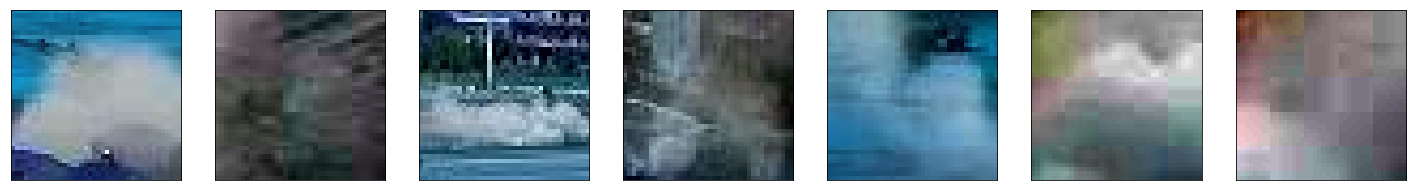

In [22]:
plt.figure(figsize=(25,25))
print("有明显烟/火出现的图片：")
for i in range(1,8):
    ax=plt.subplot(1,7,i)

    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(fog_contrasted[i]/255)

无明显烟/火出现的图片：


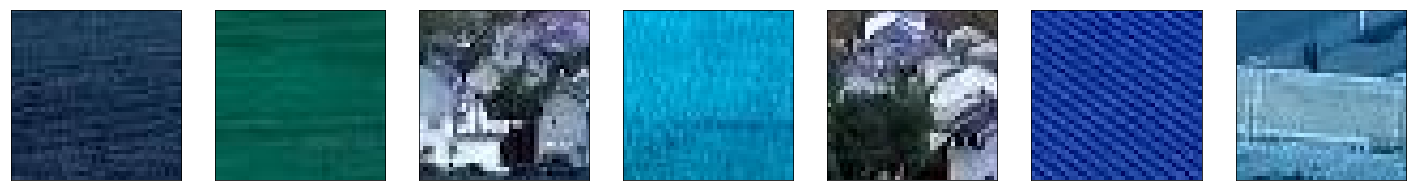

In [23]:
plt.figure(figsize=(25,25))
print("无明显烟/火出现的图片：")
for i in range(1,8):
    ax=plt.subplot(1,7,i)

    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(nofog_contrasted[i]/255)

# 数据建模
### 预先定义模型评估方法
 * 绘制混淆矩阵
 * 模型性能评估（准确率、召回率、漏报率、误报率）
 * 绘制ROC曲线

In [48]:
# 绘制混淆矩阵函数
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    
# 模型性能评估
def model_performance_evaluation(model_name, test, pred,spend_time):
    acc= accuracy_score(test, pred)
    print(model_name,  '| 准确率: %.4f' %acc)
    pred=pred.astype('float64')
    false_positive_rate,true_positive_rate,thresholds=roc_curve(test, pred)
    roc_auc=auc(false_positive_rate, true_positive_rate)
    print(model_name,  '| AUC: %.4f' %roc_auc)
    cm=confusion_matrix(test,pred)
    miss_report=cm[0][1] / (1.0 * cm[0][1] + cm[1][1])
    false_report=cm[1][0] / (1.0 * cm[0][0] + cm[1][0])
    print(model_name,"| 漏报率为：%.4f"%miss_report)
    print(model_name,"| 误报率为：%.4f"%false_report)
    print(model_name,"| 训练时长（秒）：%.4f"%spend_time)
    return acc,roc_auc,miss_report,false_report,spend_time
    
#绘制ROC曲线
def plot_ROC_curve(y_test,y_predict):
    false_positive_rate,true_positive_rate,thresholds=roc_curve(y_test, y_predict)
    roc_auc=auc(false_positive_rate, true_positive_rate)
    plt.title('ROC')
    plt.plot(false_positive_rate, true_positive_rate,'b',label='AUC = %0.2f'% roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'r--')
    plt.ylabel('TPR')
    plt.xlabel('FPR')
    plt.show()



### 使用传统机器学习模型：支持向量机、随机森林、神经网络、集成学习Adaboost进行训练

In [68]:

def train_model(label,data,model_name):
    '''
    data:训练数据
    model_name:模型名称
    model:sklearn模型
    '''
    y=label
    X=data
    #划分数据集
    X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.1,random_state=0)

    #搜索最优参数
    if model_name=='随机森林':
         grid=RandomForestClassifier(n_estimators=100,min_samples_leaf=10,random_state = 0)
    
    if model_name=='支持向量机':
        grid=SVC(kernel='rbf',C=10,random_state = 0)
        
    if model_name=='神经网络':
        grid=MLPClassifier(random_state =0)
    
    if model_name=='adaboost':
        grid=AdaBoostClassifier(n_estimators=100,random_state = 0)
    #模型训练
    clf=grid
    start = time.time()
    model=clf.fit(X_train,y_train)
    end=time.time()
    spend_time=end-start
    
    #模型评估
    y_pred=model.predict(X_test)
    # 绘制混淆矩阵
    print(model_name+"分类评估报告")
    cnf_matrix = confusion_matrix(y_test, y_pred)
    np.set_printoptions(precision=2)  # 设置打印数量的阈值
    class_names = [0,1]
    test_report=classification_report(y_test,y_pred)
    print(test_report)
    plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion matrix')
    plot_ROC_curve(y_test,y_pred)
    
    print(model_name+"在训练集上的性能 -- ")
    model_performance_evaluation(model_name, y_train, clf.predict(X_train),spend_time)
    print("=========================================")
    print(model_name+"在测试集上的性能 -- ")
    return list(model_performance_evaluation(model_name, y_test, y_pred,spend_time))


In [69]:
from sklearn.preprocessing import StandardScaler
data=df[df.columns[:-1]]
label=df['label']
#数据标准化
scaler = StandardScaler()
data= scaler.fit_transform(data)

随机森林分类评估报告
             precision    recall  f1-score   support

          0       0.83      0.87      0.85       197
          1       0.84      0.79      0.81       164

avg / total       0.83      0.83      0.83       361



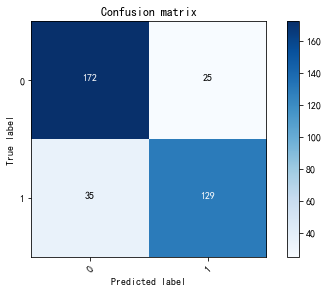

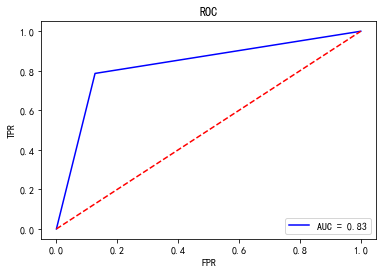

随机森林在训练集上的性能 -- 
随机森林 | 准确率: 0.9406
随机森林 | AUC: 0.9386
随机森林 | 漏报率为：0.0531
随机森林 | 误报率为：0.0643
随机森林 | 训练时长（秒）：7.1245
随机森林在测试集上的性能 -- 
随机森林 | 准确率: 0.8338
随机森林 | AUC: 0.8298
随机森林 | 漏报率为：0.1623
随机森林 | 误报率为：0.1691
随机森林 | 训练时长（秒）：7.1245


In [72]:
RF_result=train_model(label,data,"随机森林")

支持向量机分类评估报告
             precision    recall  f1-score   support

          0       0.90      0.82      0.86       197
          1       0.81      0.89      0.85       164

avg / total       0.86      0.85      0.85       361



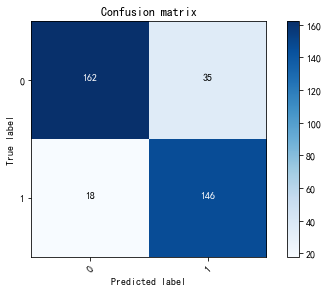

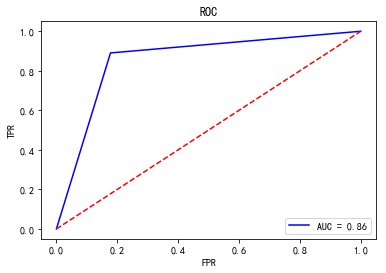

支持向量机在训练集上的性能 -- 
支持向量机 | 准确率: 0.9717
支持向量机 | AUC: 0.9731
支持向量机 | 漏报率为：0.0483
支持向量机 | 误报率为：0.0109
支持向量机 | 训练时长（秒）：12.2925
支持向量机在测试集上的性能 -- 
支持向量机 | 准确率: 0.8532
支持向量机 | AUC: 0.8563
支持向量机 | 漏报率为：0.1934
支持向量机 | 误报率为：0.1000
支持向量机 | 训练时长（秒）：12.2925


In [73]:
SVM_result=train_model(label,data,"支持向量机")

神经网络分类评估报告
             precision    recall  f1-score   support

          0       0.81      0.65      0.72       197
          1       0.66      0.82      0.73       164

avg / total       0.74      0.73      0.73       361



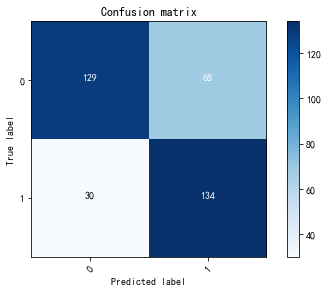

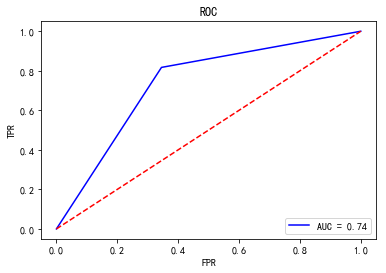

神经网络在训练集上的性能 -- 
神经网络 | 准确率: 0.9704
神经网络 | AUC: 0.9710
神经网络 | 漏报率为：0.0418
神经网络 | 误报率为：0.0193
神经网络 | 训练时长（秒）：10.2106
神经网络在测试集上的性能 -- 
神经网络 | 准确率: 0.7285
神经网络 | AUC: 0.7359
神经网络 | 漏报率为：0.3366
神经网络 | 误报率为：0.1887
神经网络 | 训练时长（秒）：10.2106


In [74]:
MLP_result=train_model(label,data,"神经网络")

adaboost分类评估报告
             precision    recall  f1-score   support

          0       0.77      0.64      0.70       197
          1       0.64      0.77      0.70       164

avg / total       0.71      0.70      0.70       361



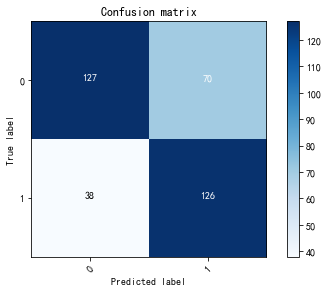

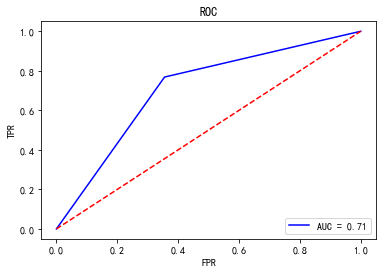

adaboost在训练集上的性能 -- 
adaboost | 准确率: 0.8150
adaboost | AUC: 0.8167
adaboost | 漏报率为：0.2282
adaboost | 误报率为：0.1445
adaboost | 训练时长（秒）：37.8667
adaboost在测试集上的性能 -- 
adaboost | 准确率: 0.7008
adaboost | AUC: 0.7065
adaboost | 漏报率为：0.3571
adaboost | 误报率为：0.2303
adaboost | 训练时长（秒）：37.8667


In [75]:
ADA_result=train_model(label,data,"adaboost")

# 使用CNN进行建模训练

In [76]:
import keras
from keras.preprocessing.image import img_to_array#图片转为array
from keras.utils import to_categorical#相当于one-hot
from sklearn.model_selection import train_test_split
import numpy as np
import random
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,BatchNormalization,Dropout
from keras.optimizers import SGD
from keras.models import Sequential
from keras.optimizers import RMSprop
import keras.backend as K

Using TensorFlow backend.


Epoch 1/30
101/101 [==============================] - 21s 208ms/step - loss: 0.4680 - accuracy: 0.7752 - val_loss: 0.3892 - val_accuracy: 0.8338
Epoch 2/30
101/101 [==============================] - 20s 203ms/step - loss: 0.3881 - accuracy: 0.8346 - val_loss: 0.2984 - val_accuracy: 0.8670
Epoch 3/30
101/101 [==============================] - 22s 213ms/step - loss: 0.3372 - accuracy: 0.8595 - val_loss: 0.3227 - val_accuracy: 0.8587
Epoch 4/30
101/101 [==============================] - 21s 204ms/step - loss: 0.2974 - accuracy: 0.8750 - val_loss: 0.2847 - val_accuracy: 0.8947
Epoch 5/30
101/101 [==============================] - 20s 202ms/step - loss: 0.2841 - accuracy: 0.8859 - val_loss: 0.2433 - val_accuracy: 0.8920
Epoch 6/30
101/101 [==============================] - 21s 206ms/step - loss: 0.2757 - accuracy: 0.8912 - val_loss: 0.3759 - val_accuracy: 0.8338
Epoch 7/30
101/101 [==============================] - 20s 202ms/step - loss: 0.2710 - accuracy: 0.8930 - val_loss: 0.2390 - val_ac

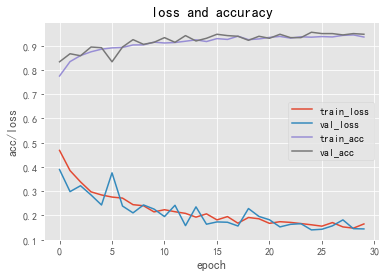

618.6195929050446

In [132]:

def cnn(channel,height,width,classes):
    input_shape = (channel,height,width)
    if K.image_data_format() == "channels_last":
        input_shape = (height,width,channel)
    model = Sequential()
    model.add(Conv2D(32,(5,5),padding="same",activation="relu",input_shape=input_shape,name="conv1"))
    model.add(Conv2D(32,(5,5),padding="same",activation="relu",name="conv2"))
    model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2),name="pool1"))
    
    model.add(Conv2D(64,(3,3),padding="same",activation="relu",name="conv3"))
    model.add(Conv2D(64,(3,3),padding="same",activation="relu",name="conv4"))
    model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2),name="pool2"))

    # 全连接层,展开操作，
    model.add(Flatten())
    model.add(Dense(256,activation="relu",name="fc1"))
    model.add(Dense(classes,activation="softmax",name="fc2"))
    return model

def train(aug, model,train_x,train_y,test_x,test_y):
    start=time.time()
    model.compile(loss="categorical_crossentropy",optimizer="Adam",metrics=["accuracy"])
    _history = model.fit_generator(aug.flow(train_x,train_y,batch_size=batch_size),
                        validation_data=(test_x,test_y),steps_per_epoch=len(train_x)//batch_size,
                        epochs=epochs,verbose=1)
    end=time.time()
    spend_time=end-start

    plt.figure()
    N = epochs
    #model的history有四个属性，loss,val_loss,acc,val_acc
    plt.plot(np.arange(0,N),_history.history["loss"],label ="train_loss")
    plt.plot(np.arange(0,N),_history.history["val_loss"],label="val_loss")
    plt.plot(np.arange(0,N),_history.history["accuracy"],label="train_acc")
    plt.plot(np.arange(0,N),_history.history["val_accuracy"],label="val_acc")
    plt.title("loss and accuracy")
    plt.xlabel("epoch")
    plt.ylabel("acc/loss")
    plt.legend(loc="best")
#     plt.savefig("../result/result.png")
    plt.show()
    return spend_time


#模型参数设置
channel = 1
height = 40
width = 40
class_num = 2
norm_size = 32#参数
batch_size = 32
epochs = 30

data=data.reshape(-1,40,40,1)
label=np.array(df['label'].astype('int'))
label = to_categorical(label)
train_x,test_x, train_y,test_y = train_test_split(data,label,test_size=0.1,random_state=0)
#构建模型
model = cnn(channel=channel, height=height,width=width, classes=class_num)

aug = ImageDataGenerator(rotation_range=30,width_shift_range=0.1,
                   height_shift_range=0.1,shear_range=0.2,zoom_range=0.2,
                   horizontal_flip=True,fill_mode="nearest")#数据增强，生成迭代器


spend_time=train(aug,model,train_x,train_y,test_x,test_y)#训练
spend_time

-----------------
cnn测试集分类报告:
              precision    recall  f1-score   support

          0       0.94      0.96      0.95       197
          1       0.96      0.93      0.94       164

avg / total       0.95      0.95      0.95       361

cnn | 准确率: 0.9474
cnn | AUC: 0.9456
cnn | 漏报率为：0.0440
cnn | 误报率为：0.0594
cnn | 训练时长（秒）：618.6196


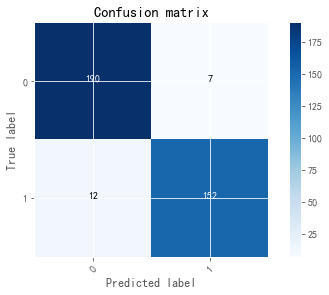

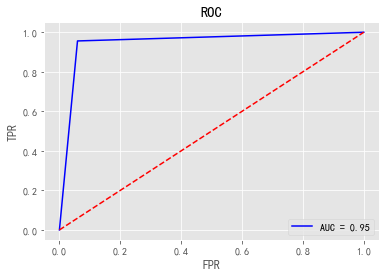

In [133]:
pred= model.predict(test_x, batch_size=32)

pred=pred.argmax(axis=1)
testY=test_y.argmax(axis=1)

test_acc=accuracy_score(testY,pred)
cnf_matrix=confusion_matrix(testY,pred)

test_report=classification_report(testY,pred)
print("-----------------")
print("cnn测试集分类报告:\n",test_report)

CNN_result=model_performance_evaluation("cnn",testY,pred,spend_time)
plot_confusion_matrix(cnf_matrix, classes=[0,1], title='Confusion matrix')
plot_ROC_curve(pred,testY)

# 模型性能评估，以及不同模型性能比较

In [138]:
result=pd.DataFrame({
    "随机森林":RF_result,
    "支持向量机":SVM_result,
    "神经网络":MLP_result,
    "Adaboost":ADA_result,
    "CNN":CNN_result,
    "Name":["准确率","AUC","漏报率","误报率","训练时长"]
})
result=result.set_index("Name")
result= pd.DataFrame(result.values.T, index=result.columns, columns=result.index)
result

Name,准确率,AUC,漏报率,误报率,训练时长
随机森林,0.833795,0.829841,0.162338,0.169082,7.124548
支持向量机,0.853186,0.856289,0.193370,0.100000,12.292464
神经网络,0.728532,0.735948,0.336634,0.188679,10.210611
Adaboost,0.700831,0.706481,0.357143,0.230303,37.866674
CNN,0.947368,0.945648,0.044025,0.059406,618.619593


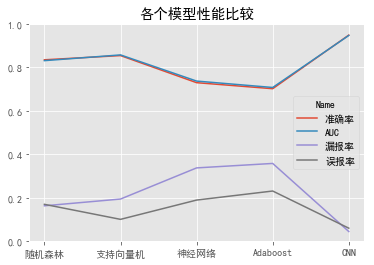

In [139]:
result.iloc[:,:-1].plot()
plt.title("各个模型性能比较")
plt.xticks(np.arange(5),result.index)
plt.ylim([0,1])
plt.show()

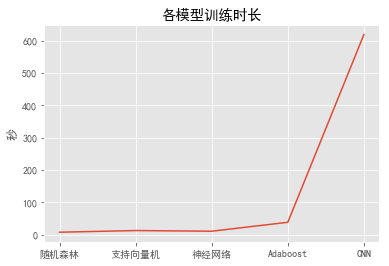

In [137]:
result['训练时长'].plot(title="各模型训练时长")
plt.xticks(np.arange(5),result.index)
plt.ylabel("秒")
plt.show()

### 对于误报率与漏报率，相对而言，漏报率更重要。对于误报率偏高我们可以通过优化算法降低这个结果。但是当漏报率偏高时，会对模型最后的结果影响较大，很可能会使得实际的应用中不能有效地发挥作用，同时也会增加人工的筛查操作，降低效率。
### 由上可见，使用CNN的效果最好，准确率为0.94，AUC为0.94。相比传统机器学习模型，准确率有显著的提升
